In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# If you launched the notebook from the project root (the folder that contains both "tests/" and "fiberphotometry/"),
# then Path.cwd() is already the project root:
project_root = Path.cwd()

# If for some reason your notebook’s working directory is "tests/", you can step up one level:
if not (project_root / "fiberphotometry").exists():
    project_root = project_root.parent

# Now insert that folder into Python’s import search path:
sys.path.insert(0, str(project_root))

# After this, the import should work:
from fiberphotometry.data.data_loading import load_all_sessions
from fiberphotometry.data.session_loading import populate_containers
from fiberphotometry.data.oft_session_loading import populate_oft_containers

In [3]:
path = Path("/Users/fsp585/Desktop/GetherLabCode/FiberphotometryCode/src_oft/jonathan/Jonathan_IFxDN_csvs")

In [4]:
sessions = load_all_sessions(
        baseline_dir=str(path),
        session_type="oft",
        first_n_dirs=3,
        remove_bad_signal_sessions=True
        )

Processing trial directories: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


In [5]:
populate_containers(sessions)

In [6]:
populate_oft_containers(sessions, '/Users/fsp585/Desktop/GetherLabCode/FiberphotometryCode/src_oft/jonathan/h5_files', 
                        '/Users/fsp585/Desktop/GetherLabCode/FiberphotometryCode/src_oft/jonathan/selected_13T_files')

Loaded sync data for session T1_1658.740.1666.e/A from: CenterTopCam_AllTimestampsCombined2024-12-13T12_20_06.csv as sync_0
Loaded sync data for session T1_1658.740.1666.e/A from: LeftTopCam_AllTimestampsCombined2024-12-13T12_20_06.csv as sync_1
Loaded sync data for session T1_1658.740.1666.e/B from: CenterTopCam_AllTimestampsCombined2024-12-13T12_20_06.csv as sync_0
Loaded sync data for session T1_1658.740.1666.e/B from: LeftTopCam_AllTimestampsCombined2024-12-13T12_20_06.csv as sync_1
Loaded sync data for session T1_1658.740.1666.e/C from: CenterTopCam_AllTimestampsCombined2024-12-13T12_20_06.csv as sync_0
Loaded sync data for session T1_1658.740.1666.e/C from: RightTopCam_AllTimestampsCombined2024-12-13T12_20_06.csv as sync_1
Loaded sync data for session T2_1664.1678.e.e/A from: CenterTopCam_AllTimestampsCombined2024-12-13T13_37_45.csv as sync_0
Loaded sync data for session T2_1664.1678.e.e/A from: LeftTopCam_AllTimestampsCombined2024-12-13T13_37_45.csv as sync_1
Loaded sync data fo

In [7]:
import pandas as pd
from pathlib import Path
import os
import re

def simplify_filename_details(filename: str) -> str:
    """
    Finds all occurrences of spatial keywords in a filename and joins them.
    It includes 'top' only if it appears in lowercase, to avoid matching
    camera names like 'CenterTopCam'.
    """
    keywords = ['left', 'right', 'bottom', 'top', 'upper', 'lower']
    pattern = r'|'.join(keywords)
    matches = re.finditer(pattern, filename, flags=re.IGNORECASE)
    
    final_words = []
    for match in matches:
        word = match.group(0)
        if word.lower() == 'top':
            if word == 'top':
                final_words.append(word)
        else:
            final_words.append(word)
            
    return '_'.join([w.capitalize() for w in final_words])

# 1. Create a flat list of records
records = []
for s in sessions:
    session_id = f"{s.trial_id}/{s.chamber_id}"
    trial_dir = Path(s.trial_dir)
    
    # A single loop now handles all data types
    for key, df in s.dfs.data.items():
        data_type = "unknown"
        details = "N/A"
        
        if key.startswith('phot_'):
            data_type = "photometry"
            details = "Photometry Data"

        elif key.startswith('tracking_'):
            data_type = "tracking_h5"
            path_col = df.columns[0]
            filename = os.path.basename(df[path_col].iloc[0])
            details = simplify_filename_details(filename)

        elif key.startswith('video_'):
            data_type = "video_mp4"
            path_col = df.columns[0]
            filename = os.path.basename(df[path_col].iloc[0])
            details = simplify_filename_details(filename)
        
        elif key.startswith('sync_'):
            data_type = "sync_csv"
            
            # --- THIS BLOCK IS NOW CORRECTED ---
            try:
                # 1. Get the camera name from the new column inside the dataframe
                cam_name = df['camera_name'].iloc[0]
                
                # 2. Now use that correct camera name to find the file path
                path = next(trial_dir.glob(f'{cam_name}_AllTimestampsCombined*.csv'))
                details = simplify_filename_details(path.name)
            except (StopIteration, KeyError, IndexError):
                # Catch errors if column/file is missing or df is empty
                details = "Info not available"
                
        else:
            continue
            
        records.append((session_id, data_type, key, details))

# 2. Convert the list of records into the final DataFrame
summary_df = pd.DataFrame(records, 
                          columns=['Session ID', 'Data Type', 'Source Key', 'Simplified Details'])

# 3. Sort the data for better readability
summary_df = summary_df.sort_values(by=['Session ID', 'Data Type', 'Source Key']).reset_index(drop=True)

with pd.option_context('display.max_rows', None):
    display(summary_df)

,Session ID,Data Type,Source Key,Simplified Details
0,T1_1658.740.1666.e/A,photometry,phot_415,Photometry Data
1,T1_1658.740.1666.e/A,photometry,phot_470,Photometry Data
2,T1_1658.740.1666.e/A,sync_csv,sync_0,
3,T1_1658.740.1666.e/A,sync_csv,sync_1,Left
4,T1_1658.740.1666.e/A,tracking_h5,tracking_0,Top_Left
5,T1_1658.740.1666.e/A,tracking_h5,tracking_1,Left_Upper
6,T1_1658.740.1666.e/A,video_mp4,video_0,Top_Left
7,T1_1658.740.1666.e/A,video_mp4,video_1,Left_Upper
8,T1_1658.740.1666.e/B,photometry,phot_415,Photometry Data
9,T1_1658.740.1666.e/B,photometry,phot_470,Photometry Data


In [8]:
sessions[0].dfs.data.keys()

dict_keys(['phot_415', 'phot_470', 'sync_0', 'sync_1', 'tracking_0', 'tracking_1', 'video_0', 'video_1'])

In [9]:
for df_name, df in sessions[0].dfs.data.items():
    print(df_name, df.columns)

phot_415 Index(['FrameCounter', 'SystemTimestamp', 'LedState', 'ComputerTimestamp',
       'signal_0', 'signal_1'],
      dtype='object')
phot_470 Index(['FrameCounter', 'SystemTimestamp', 'LedState', 'ComputerTimestamp',
       'signal_0', 'signal_1'],
      dtype='object')
sync_0 Index(['Cam_Bonsai_Timestamp', 'Cam_Basler_Timestamp',
       'FP3002_Bonsai_Timestamp', 'FP3002_System_Timestamp', 'camera_name'],
      dtype='object')
sync_1 Index(['Cam_Bonsai_Timestamp', 'Cam_Basler_Timestamp',
       'FP3002_Bonsai_Timestamp', 'FP3002_System_Timestamp', 'camera_name'],
      dtype='object')
tracking_0 Index(['h5_path', 'camera_name'], dtype='object')
tracking_1 Index(['h5_path', 'camera_name'], dtype='object')
video_0 Index(['path', 'camera_name'], dtype='object')
video_1 Index(['path', 'camera_name'], dtype='object')


In [10]:
# In your notebook

# 1. Import the finalized synchronization function
from fiberphotometry.data.session_synchronization import synchronize_session_data
import pprint # Use pprint for a more readable list of columns

# 2. Select a session to process
s0 = sessions[0]

# 3. Run the synchronization
print("Starting synchronization...")
synchronize_session_data(s0, downsample_video_by=2, tolerance=0.02)
print("\nSynchronization function finished.")

# 4. Verify the final structure of ALL created DataFrames
print("="*50)
print("VERIFICATION OF FINAL DATAFRAME STRUCTURE")
print("="*50)

# Get all keys that were created by the sync function
sync_keys = sorted([k for k in s0.dfs.data if k.startswith('synchronized_')])

if not sync_keys:
    print("\nNo synchronized DataFrames were found in the session.")
else:
    for key in sync_keys:
        final_df = s0.dfs.data[key]
        print(f"\n--- Verification for: {key} ---")
        print(f"Total number of rows: {len(final_df)}")
        print(f"Total number of columns: {len(final_df.columns)}")
        print("Final Columns:")
        # Pretty-print the list of all columns for a complete check
        pprint.pprint(final_df.columns.to_list())

Starting synchronization...
--- Synchronizing all pairs for session: T1_1658.740.1666.e/A ---

Processing pair for camera: 'CenterTopCam' (from tracking_0)
Master timeline established with 319144 rows.
✅ Successfully created 'synchronized_data_tracking_0' with 319144 rows and 5 columns.

Processing pair for camera: 'LeftTopCam' (from tracking_1)
Master timeline established with 319143 rows.
✅ Successfully created 'synchronized_data_tracking_1' with 319143 rows and 5 columns.

--- Synchronization complete for all pairs ---

Synchronization function finished.
VERIFICATION OF FINAL DATAFRAME STRUCTURE

--- Verification for: synchronized_data_tracking_0 ---
Total number of rows: 319144
Total number of columns: 5
Final Columns:
['FP3002_System_Timestamp',
 'signal_0_470',
 'signal_0_415',
 'curr_video_frame',
 'current_h5_row']

--- Verification for: synchronized_data_tracking_1 ---
Total number of rows: 319143
Total number of columns: 5
Final Columns:
['FP3002_System_Timestamp',
 'signal_0

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319143 entries, 0 to 319142
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FP3002_System_Timestamp  319143 non-null  float64
 1   signal_0_470             239352 non-null  float64
 2   signal_0_415             239314 non-null  float64
 3   curr_video_frame         319143 non-null  int64  
 4   current_h5_row           319143 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 12.2 MB


In [12]:
for df_name, df in s0.dfs.data.items():
    if df_name.startswith('video') or df_name.startswith('tracking'):
        print(df_name, df)

tracking_0                                              h5_path   camera_name
0  /Users/fsp585/Desktop/GetherLabCode/Fiberphoto...  CenterTopCam
tracking_1                                              h5_path camera_name
0  /Users/fsp585/Desktop/GetherLabCode/Fiberphoto...  LeftTopCam
video_0                                                 path   camera_name
0  /Users/fsp585/Desktop/GetherLabCode/Fiberphoto...  CenterTopCam
video_1                                                 path camera_name
0  /Users/fsp585/Desktop/GetherLabCode/Fiberphoto...  LeftTopCam


In [13]:
from fiberphotometry.kpms.syllable_generator import generate_syllable_models
from fiberphotometry.kpms.syllable_appender import extract_and_append_results

print("Successfully imported syllable analysis modules!")

Successfully imported syllable analysis modules!


In [14]:
# --- Define parameters for the FULL run ---
PROJECT_DIR_FULL = "./kpms_full_run"  # Using a new directory for the full analysis
KAPPA = 1.205e+06

# --- Run the model generation process on ALL sessions ---
print("--- 🚀 STARTING SYLLABLE MODEL GENERATION (FULL RUN) ---")

# Capture all three return values from the function
model_names, video_frame_indexes, original_lengths = generate_syllable_models(
    sessions=sessions,
    project_dir=PROJECT_DIR_FULL, # Use the new directory
    kappa=KAPPA,
    num_models=1,               # You can increase this for a more robust model (e.g., 3)
    ar_iters=1,
    fitting_iters=1,
    test_mode=False             # <-- Set to False to process all files
)

print(f"\n--- ✅ FULL MODEL GENERATION FINISHED. {len(model_names)} model(s) created. ---")

2025-06-18 14:53:18,714 - INFO - Using existing project directory: './kpms_full_run'
2025-06-18 14:53:18,740 - INFO - Finding H5 paths and assigning them to session objects...
2025-06-18 14:53:18,741 - INFO - Found 8 total H5 files to process.


--- 🚀 STARTING SYLLABLE MODEL GENERATION (FULL RUN) ---


Loading keypoints: 100%|██████████████████| 8/8 [00:01<00:00,  7.06it/s]
/opt/miniconda3/envs/keypoint_moseq/lib/python3.10/site-packages/keypoint_moseq/util.py:1100: UserWarning:

Negative confidence values are not allowed and will be set to 0.

2025-06-18 14:53:29,706 - INFO - No existing PCA model found. Fitting and saving a new one.


Interpolating 189945 (0.6%) low-confidence keypoints


2025-06-18 14:53:33,074 - INFO - --- Processing model index: 0 ---


PCA: Fitting PCA model to 10000 data points
Interpolating 189945 (0.6%) low-confidence keypoints
Keypoint SLDS: Initializing hyperparameters
Keypoint SLDS: Initializing noise prior
Keypoint SLDS: Initializing parameters
Keypoint SLDS: Initializing states
Outputs will be saved to ./kpms_full_run/2025_06_18-14_53_42


100%|█████████████████████████████████████| 2/2 [00:21<00:00, 10.85s/it]


Outputs will be saved to ./kpms_full_run/final_model_1.20e+06_idx0


Reindexing: 100%|█████████████| 2/2 [00:00<00:00,  3.11model snapshot/s]
2025-06-18 14:59:26,257 - INFO - Completed model fitting. Final model name: 'final_model_1.20e+06_idx0'.
2025-06-18 14:59:26,272 - INFO - Model fitting complete.



--- ✅ FULL MODEL GENERATION FINISHED. 1 model(s) created. ---


In [15]:
video_frame_indexes.values()

dict_values([array([69521, 69522, 69523, ..., 98631, 98632, 98633]), array([100461, 100462, 100463, ..., 199772, 199773, 199774]), array([200702, 200703, 200704, ..., 292747, 292748, 292749]), array([ 92167,  92168,  92169, ..., 310627, 310628, 310629]), array([ 39631,  39632,  39633, ..., 271002, 271003, 271004]), array([ 44802,  44803,  44804, ..., 176667, 176668, 176669]), array([185452, 185453, 185454, ..., 217258, 217259, 217260]), array([232280, 232281, 232282, ..., 265253, 265254, 265255]), array([ 19499,  19500,  19501, ..., 242293, 242294, 242295]), array([ 41519,  41520,  41521, ..., 263364, 263365, 263366]), array([ 67039,  67040,  67041, ..., 247178, 247179, 247180]), array([250098, 250099, 250100, ..., 292598, 292599, 292600]), array([ 20400,  20401,  20402, ..., 241946, 241947, 241948])])

In [16]:
import numpy as np

In [17]:
# This single cell runs the appender AND verifies the result for ALL sessions.

if 'model_names' in locals() and model_names:
    
    # --- 1. RUN THE SYLLABLE APPENDER ---
    
    model_to_use = model_names[0]
    print(f"--- 📎 Appending and aligning results for model: {model_to_use} ---")
    
    extract_and_append_results(
        sessions=sessions,
        project_dir=PROJECT_DIR_FULL, # Use the new directory
        model_name=model_to_use,
        video_frame_indexes=video_frame_indexes,
        original_lengths=original_lengths
    )
    
    # --- 2. VERIFY THE RESULTS FOR ALL SESSIONS ---
    
    print("\n--- 🔍 VERIFICATION ---")
    successful_sessions = 0
    for s in sessions:
        if hasattr(s, 'all_results'):
            print(f"✅ Success! Found aligned results dictionary for session with trial_id: {s.trial_id}")
            successful_sessions += 1
            # To avoid flooding the output, we'll only display details for the first one found.
            if successful_sessions == 1:
                results_dict = s.all_results
                print(f"   (Sample) Result keys: {list(results_dict.keys())}")
                syllable_array = results_dict['syllable']
                print(f"   (Sample) Shape of padded 'syllable' array: {syllable_array.shape}")
        else:
            print(f"❌ Verification failed for session with trial_id: {s.trial_id}")

    print(f"\n--- ✅ Verification Complete: {successful_sessions} out of {len(sessions)} sessions were successfully processed. ---")

else:
    print("--- ❌ MODEL GENERATION STEP DID NOT RUN OR FAILED. SKIPPING. ---")

2025-06-18 14:59:26,967 - INFO - --- Starting syllable extraction and alignment for model: final_model_1.20e+06_idx0 ---


--- 📎 Appending and aligning results for model: final_model_1.20e+06_idx0 ---


2025-06-18 14:59:27,377 - INFO - Successfully loaded model 'final_model_1.20e+06_idx0' from checkpoint 2.
2025-06-18 14:59:27,435 - INFO - Successfully extracted results for 13 video parts.
2025-06-18 14:59:27,443 - INFO - Created final aligned data structure for session T1_1658.740.1666.e.
2025-06-18 14:59:27,456 - INFO - Created final aligned data structure for session T1_1658.740.1666.e.
2025-06-18 14:59:27,470 - INFO - Created final aligned data structure for session T1_1658.740.1666.e.
2025-06-18 14:59:27,479 - INFO - Created final aligned data structure for session T2_1664.1678.e.e.
2025-06-18 14:59:27,486 - INFO - Created final aligned data structure for session T2_1664.1678.e.e.
2025-06-18 14:59:27,494 - INFO - Created final aligned data structure for session T3_1694.1680.728.e.
2025-06-18 14:59:27,502 - INFO - Created final aligned data structure for session T3_1694.1680.728.e.
2025-06-18 14:59:27,509 - INFO - Created final aligned data structure for session T3_1694.1680.728.e


--- 🔍 VERIFICATION ---
✅ Success! Found aligned results dictionary for session with trial_id: T1_1658.740.1666.e
   (Sample) Result keys: ['syllable', 'latent_state', 'centroid', 'heading']
   (Sample) Shape of padded 'syllable' array: (319144,)
✅ Success! Found aligned results dictionary for session with trial_id: T1_1658.740.1666.e
✅ Success! Found aligned results dictionary for session with trial_id: T1_1658.740.1666.e
✅ Success! Found aligned results dictionary for session with trial_id: T2_1664.1678.e.e
✅ Success! Found aligned results dictionary for session with trial_id: T2_1664.1678.e.e
✅ Success! Found aligned results dictionary for session with trial_id: T3_1694.1680.728.e
✅ Success! Found aligned results dictionary for session with trial_id: T3_1694.1680.728.e
✅ Success! Found aligned results dictionary for session with trial_id: T3_1694.1680.728.e

--- ✅ Verification Complete: 8 out of 8 sessions were successfully processed. ---


--- 📊 Generating data availability plots for all processed sessions ---

Plotting for session with trial_id: T1_1658.740.1666.e


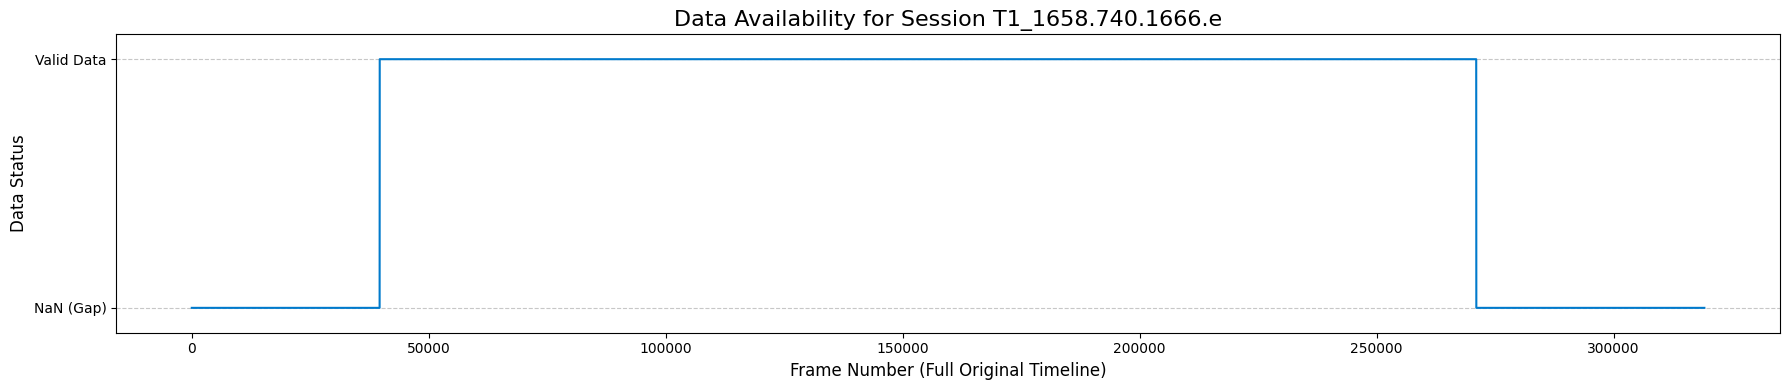


Plotting for session with trial_id: T1_1658.740.1666.e


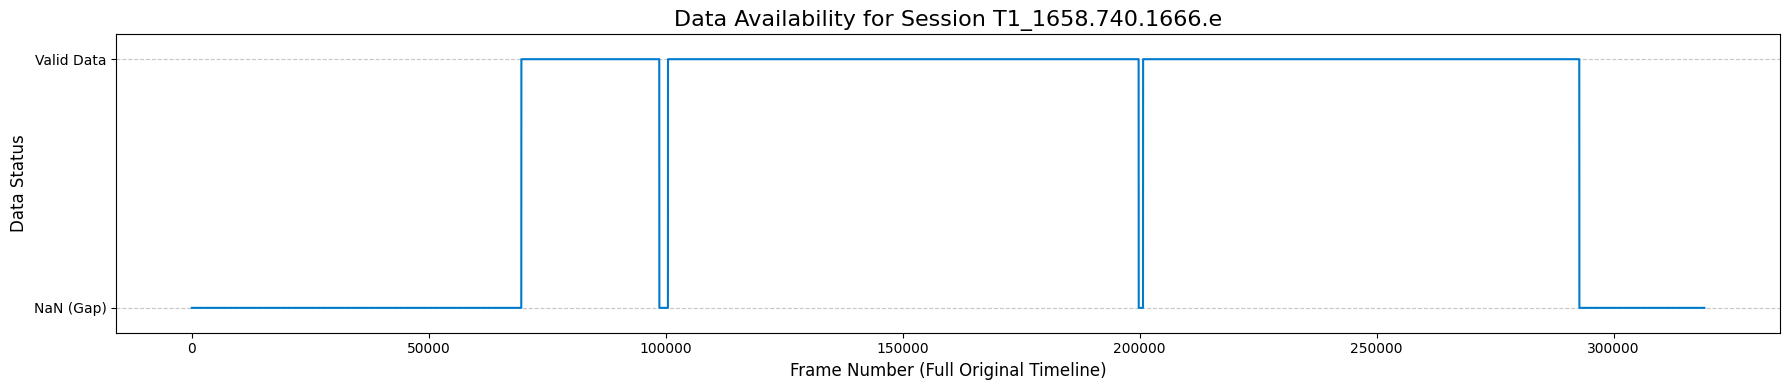


Plotting for session with trial_id: T1_1658.740.1666.e


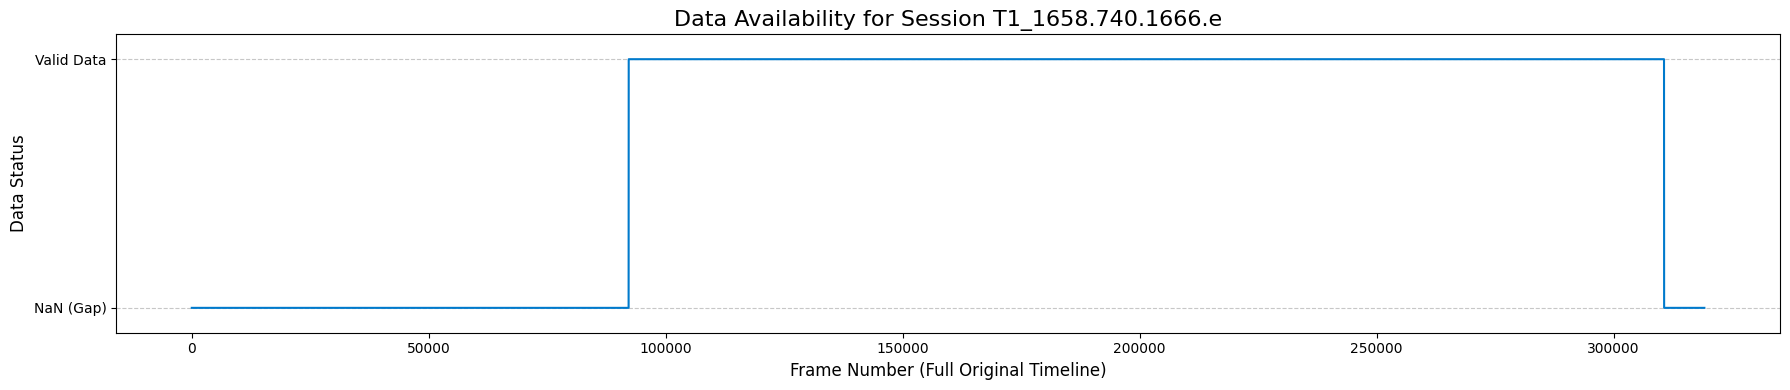


Plotting for session with trial_id: T2_1664.1678.e.e


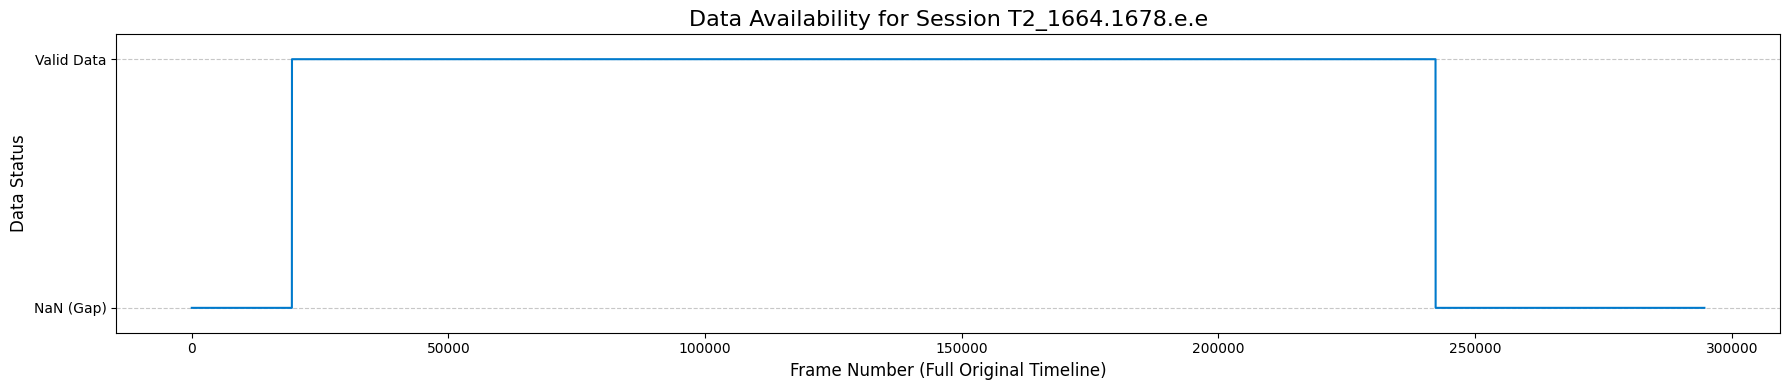


Plotting for session with trial_id: T2_1664.1678.e.e


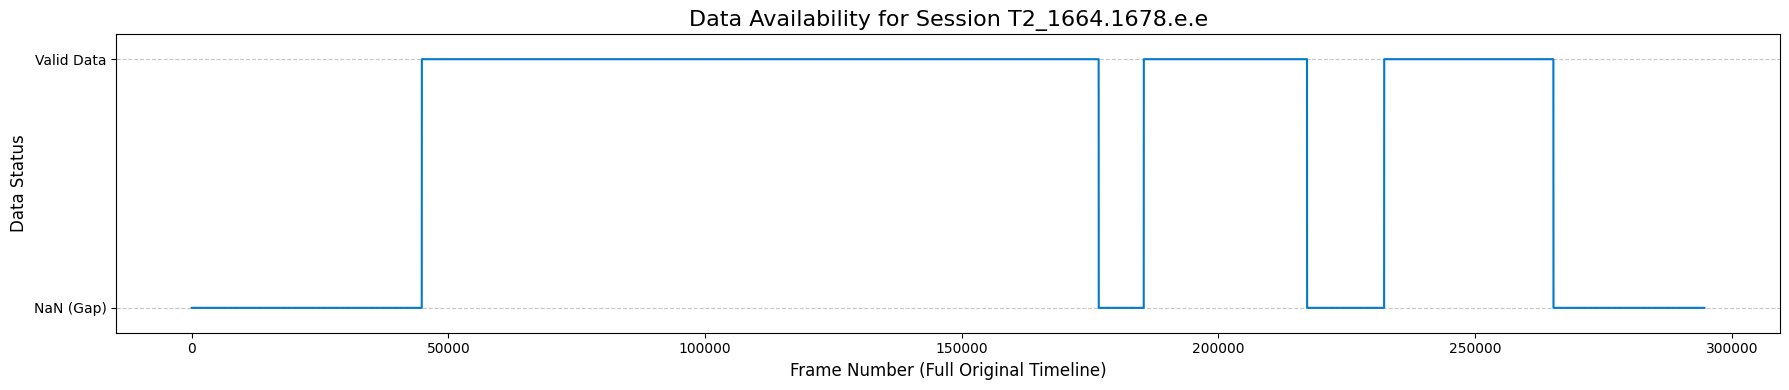


Plotting for session with trial_id: T3_1694.1680.728.e


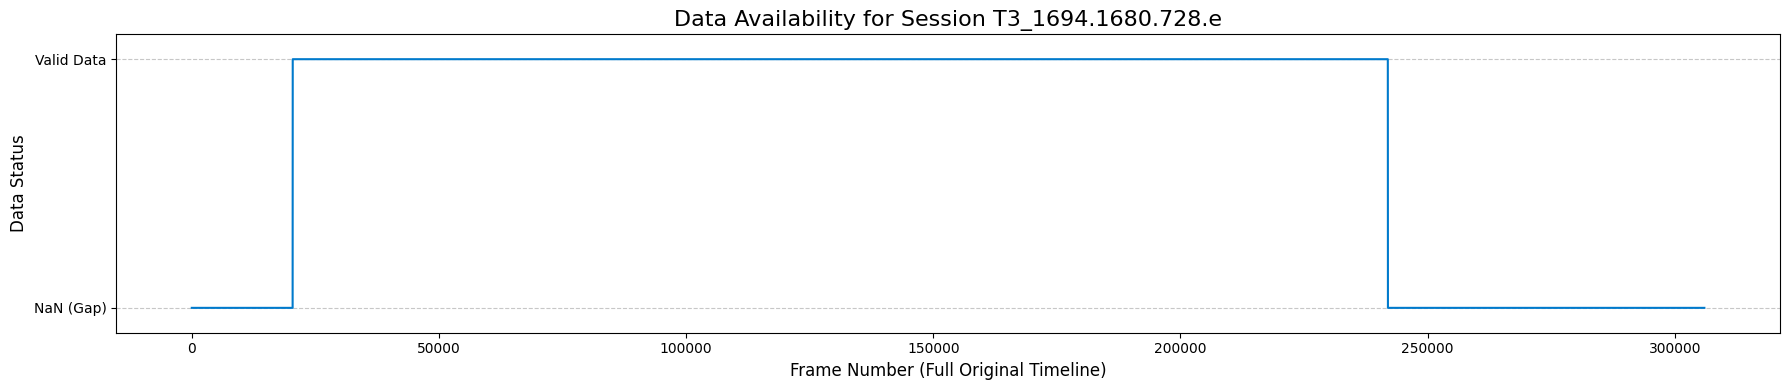


Plotting for session with trial_id: T3_1694.1680.728.e


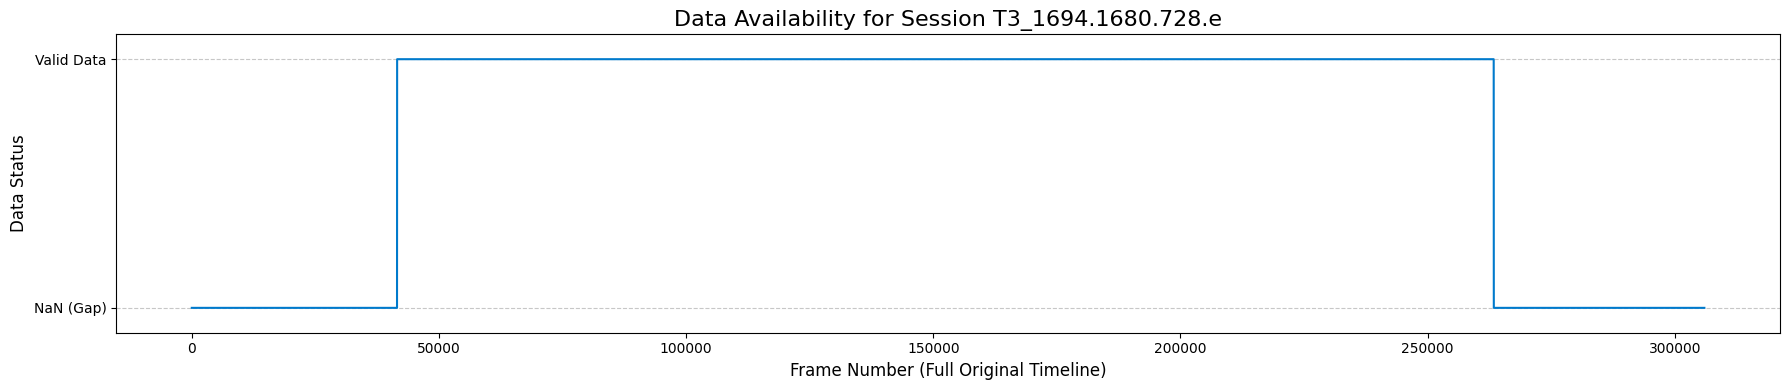


Plotting for session with trial_id: T3_1694.1680.728.e


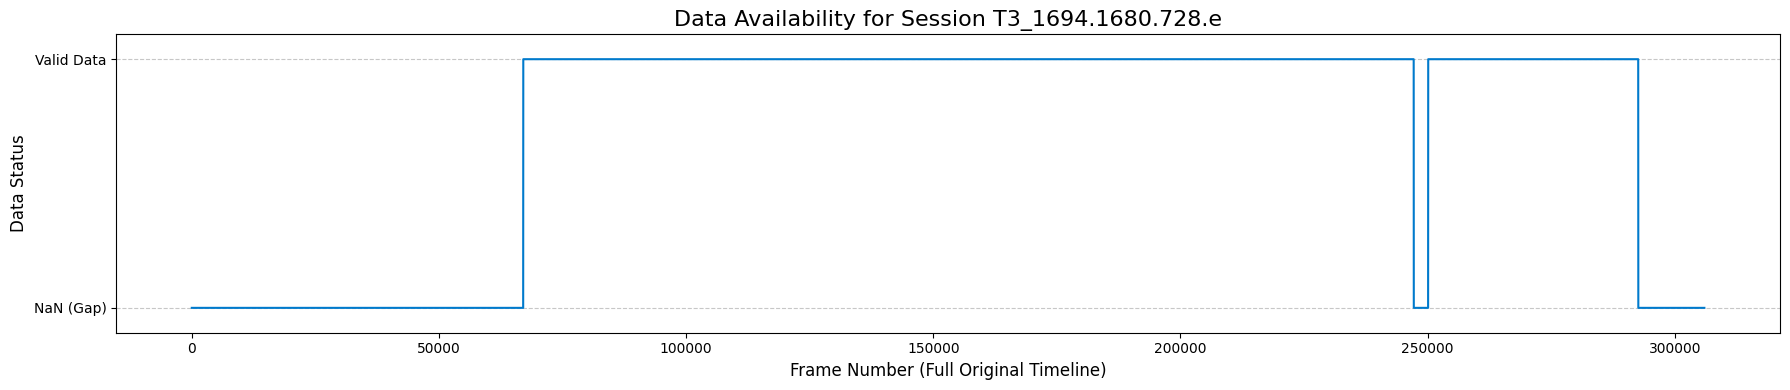


--- ✅ Plot generation complete. 8 plots created. ---


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("--- 📊 Generating data availability plots for all processed sessions ---")

# --- Loop through every session ---
plots_generated = 0
for s in sessions:
    # Check if the current session has the `all_results` attribute
    if hasattr(s, 'all_results'):
        
        # --- Create and display the plot for this specific session ---
        print(f"\nPlotting for session with trial_id: {s.trial_id}")
        
        results_dict = s.all_results
        syllable_array = results_dict['syllable']
        data_exists_mask = ~np.isnan(syllable_array)
        
        fig, ax = plt.subplots(figsize=(18, 4))
        ax.plot(data_exists_mask, color='#007acc', linewidth=1.5)
        
        # Use the current session's ID in the title
        ax.set_title(f"Data Availability for Session {s.trial_id}", fontsize=16)
        ax.set_xlabel("Frame Number (Full Original Timeline)", fontsize=12)
        ax.set_ylabel("Data Status", fontsize=12)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['NaN (Gap)', 'Valid Data'])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(-0.1, 1.1)
        
        plt.tight_layout()
        plt.show() # Display the plot for this session before creating the next one
        
        plots_generated += 1

# --- Final Summary ---
if plots_generated == 0:
    print("\n❌ No processed sessions with 'all_results' found in memory to plot.")
else:
    print(f"\n--- ✅ Plot generation complete. {plots_generated} plots created. ---")